In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob, os
import datetime
%matplotlib inline

# Reading and consolidating excel files

In [2]:
# files_path = '../data/IMU Dataset'
# files = glob.glob(files_path)
# folders = ['ADLs', 'Falls', 'Near_Falls']

# df = pd.DataFrame()

# for i in range(1,11):
#     print('Subject: '+str(i))
#     for folder in folders:
#         print('-- Trial Type: '+str(folder))
#         path = files_path+'/sub'+str(i)+'/'+str(folder)+'/*.xlsx'
#         files = glob.glob(path)

#         # create a list of dataframes, one for each file, and assign a column with the name of the file
#         dfs_list = [pd.read_excel(fp).assign(FileName = os.path.basename(fp)) for fp in files]

#         df_temp = pd.DataFrame()
#         df_temp = pd.concat(dfs_list)
#         df_temp['subject'] = i
#         df_temp['trial_type'] = folder
        
#         df = df.append(df_temp)

In [2]:
# save the dataframe in a Pickle file
# pickle.dump(df, open("full_dataset.p", "wb"))

# load the dataframe
df = pickle.load(open("full_dataset.p", "rb"))

In [2]:
# Load metadata (file genenerated in notebook exploratory_data_analysis)
meta = pickle.load(open("./metadata.p", "rb"))
meta_acceletarion = list(meta[meta.measure=='acceleration'].index)

# Dimensionality Reduction

Remove columns with independent readings of X, Y and Z to use only those consolidated using the formula:

$\sqrt{x^2 + y^2 + z^2}$

# Approach 1 - **NOT** grouping data in 2.5-second windows

### Example of a graph, similar to the ones in the paper

#### OBS: Here there is one trial (trial1), from Subject 1, subtype 'slip' from the Fall dataset

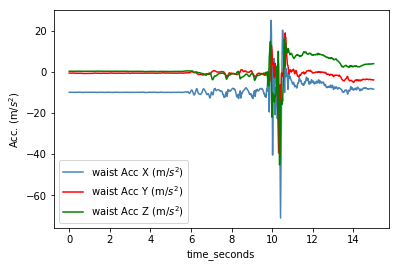

In [8]:
subtype = 'slip'
trial = 'trial1'
subject = 1
trial_type = 'Falls'
df_graph = df[(df.trial_subtype == subtype) & 
              (df.trial_num == trial) &
              (df.subject == subject) &
              (df['trial_type'] == trial_type)
             ][['Time']+meta_acceletarion]

initial_time = df_graph.Time.min()
# Setting the time in seconds and restart the time counting from the first measeure of this trial
df_graph['time_seconds'] = df_graph.Time.apply(lambda x: (x-initial_time)/1000000)

fig, ax = plt.subplots()
df_graph.set_index('time_seconds')['waist Acceleration X (m/s^2)'].plot(color='steelblue', ax=ax, label='waist Acc X (m/$s^2$)')
df_graph.set_index('time_seconds')['waist Acceleration Y (m/s^2)'].plot(color='red',ax=ax, label='waist Acc Y (m/$s^2$)')
df_graph.set_index('time_seconds')['waist Acceleration Z (m/s^2)'].plot(color='green',ax=ax, label='waist Acc Z (m/$s^2$)')
plt.ylabel('Acc. (m/$s^2$)')
ax.legend()

In [16]:
# the columns whose metadata axis = XYZ are those with the consolidation of the values
cols_to_remove = list(meta[meta.axis != 'XYZ'].index) 
cols_to_remove


['r.ankle Acceleration X (m/s^2)',
 'r.ankle Acceleration Y (m/s^2)',
 'r.ankle Acceleration Z (m/s^2)',
 'r.ankle Angular Velocity X (rad/s)',
 'r.ankle Angular Velocity Y (rad/s)',
 'r.ankle Angular Velocity Z (rad/s)',
 'r.ankle Magnetic Field X (uT)',
 'r.ankle Magnetic Field Y (uT)',
 'r.ankle Magnetic Field Z (uT)',
 'l.ankle Acceleration X (m/s^2)',
 'l.ankle Acceleration Y (m/s^2)',
 'l.ankle Acceleration Z (m/s^2)',
 'l.ankle Angular Velocity X (rad/s)',
 'l.ankle Angular Velocity Y (rad/s)',
 'l.ankle Angular Velocity Z (rad/s)',
 'l.ankle Magnetic Field X (uT)',
 'l.ankle Magnetic Field Y (uT)',
 'l.ankle Magnetic Field Z (uT)',
 'r.thigh Acceleration X (m/s^2)',
 'r.thigh Acceleration Y (m/s^2)',
 'r.thigh Acceleration Z (m/s^2)',
 'r.thigh Angular Velocity X (rad/s)',
 'r.thigh Angular Velocity Y (rad/s)',
 'r.thigh Angular Velocity Z (rad/s)',
 'r.thigh Magnetic Field X (uT)',
 'r.thigh Magnetic Field Y (uT)',
 'r.thigh Magnetic Field Z (uT)',
 'l.thigh Acceleration X (m/

In [17]:
df.drop(cols_to_remove, axis=1, inplace=True)

# Marking rows with peak

For each consolidated measure (ex: 'waist resultant acceleration') another column is created to mark the peaks.

For each trial and for each one of the measures, the column will have value 1 for the peak and value 0 for the rest.

In [4]:
# columns to get the peak
columns_to_get_peak = list(meta[meta.axis=='XYZ'].index)
columns_to_get_peak

['r.ankle resultant acceleration',
 'r.ankle resultant angular velocity',
 'r.ankle resultant magnetic field',
 'l.ankle resultant acceleration',
 'l.ankle resultant angular velocity',
 'l.ankle resultant magnetic field',
 'r.thigh resultant acceleration',
 'r.thigh resultant angular velocity',
 'r.thigh resultant magnetic field',
 'l.thigh resultant acceleration',
 'l.thigh resultant angular velocity',
 'l.thigh resultant magnetic field',
 'head resultant acceleration',
 'head resultant angular velocity',
 'head resultant magnetic field',
 'sternum resultant acceleration',
 'sternum resultant angular velocity',
 'sternum resultant magnetic field',
 'waist resultant acceleration',
 'waist resultant angular velocity',
 'waist resultant magnetic field']

In [5]:
# create the columns (add suffix ' - peak') and set value 0 by default
for col in columns_to_get_peak:
    df[col+' - peak'] = 0

In [6]:
files = list(df.FileName.unique())
for file in files:
    df_file = df[df.FileName == file]
    
    for col in columns_to_get_peak:
        
        peak = df_file[col].idxmax()
        
        #store 1 in the row with the max value (the peak)
        df.iloc[peak, df.columns.get_loc(str(col+' - peak'))] = 1

In [3]:
# # save the dataframe in a Pickle file
# pickle.dump(df, open("../data/dataset_consolidated_peak.p", "wb"))

# load the dataframe
df = pickle.load(open("../data/dataset_consolidated_peak.p", "rb"))

In [4]:
# df.FileName.unique()[0]
files = ['JXL_SQ_trial1.xlsx', 'HXE_DS_trial1.xlsx']

In [6]:
cols = ['Time', 'time_datetime', 'time_seconds', 'subject', 'trial_type',
       'trial_num', 'trial_num_original', 'trial_subtype','waist Acceleration X (m/s^2)', 'waist Acceleration Y (m/s^2)',
       'waist Acceleration Z (m/s^2)', 'waist resultant acceleration', 'waist resultant acceleration - peak', 
        'head Acceleration X (m/s^2)', 'head Acceleration Y (m/s^2)',
       'head Acceleration Z (m/s^2)', 'head resultant acceleration', 'head resultant acceleration - peak',
        'FileName']

In [7]:
df2 = df[(df.FileName == 'AXM_AS_trial1.xlsx') | 
         (df.FileName == 'HXE_DS_trial1.xlsx')][cols].sort_values(['FileName','time_seconds']).to_csv('dataset_w_peaks_full_file2.csv',index=False)

In [8]:
df[df.FileName == list(df.FileName.unique())[0]].to_csv('dataset_w_peaks_file1.csv')

In [9]:
df.columns

Index(['Time', 'time_datetime', 'time_seconds', 'subject', 'trial_type',
       'trial_num', 'trial_num_original', 'trial_subtype',
       'r.ankle Acceleration X (m/s^2)', 'r.ankle Acceleration Y (m/s^2)',
       ...
       'l.thigh resultant magnetic field - peak',
       'head resultant acceleration - peak',
       'head resultant angular velocity - peak',
       'head resultant magnetic field - peak',
       'sternum resultant acceleration - peak',
       'sternum resultant angular velocity - peak',
       'sternum resultant magnetic field - peak',
       'waist resultant acceleration - peak',
       'waist resultant angular velocity - peak',
       'waist resultant magnetic field - peak'],
      dtype='object', length=115)

### Example of graph highlighting the surrounding of the peak 

In [10]:
df_graph = df[(df.trial_num == 1) & (df.trial_subtype == 'AS') & (df.subject==1)]

In [11]:
peak_index = df_graph['waist resultant acceleration'].idxmax()
time_peak = df_graph.iloc[peak_index,df.columns.get_loc('time_seconds')]
interval = 4

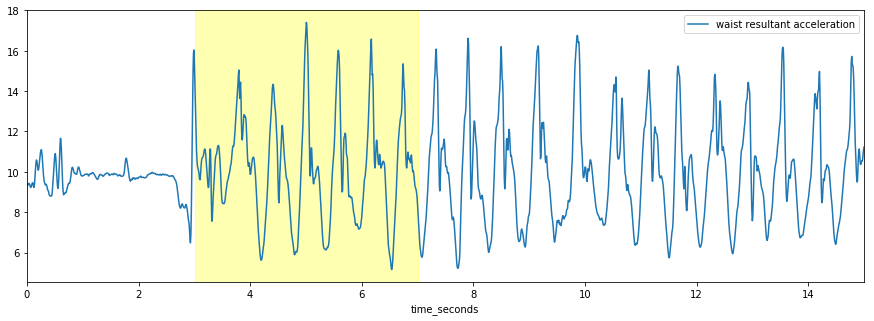

In [12]:
fig, ax = plt.subplots( figsize=(15,5))
df_graph.set_index('time_seconds')['waist resultant acceleration'].plot()
plt.axvspan(time_peak - interval/2.0, time_peak + interval/2.0, color='yellow', alpha=0.3)
ax.legend()

## Deletion of rows outsite range

Initially this will be done

In [1]:
interval = 4 # all rows round this interval will be removed

In [ ]:
files = list(df.FileName.unique())
for file in files:
    df_file = df[df.FileName == file]
    
    for col in columns_to_get_peak:
        
        peak = df_file[col].idxmax()
        
        #store 1 in the row with the max value (the peak)
        df.iloc[peak, df.columns.get_loc(str(col+' - peak'))] = 1

In [ ]:
def remove_data_around_peak(df, body_location, interval):
    columns = list(meta[(meta.body_location == body_location) & (meta.axis == 'XYZ')].index)
    df = 